In [579]:
from foobah.gcode import GCODE
from foobah.utils import preview_svg
from foobah.methods import line_threshold
from foobah import constants
from foobah.constants import XMAX, XMIN, YMAX, YMIN

import PIL
import PIL.Image
import PIL.ImageFilter

import math
import numpy as np

import random
from random import uniform
from scipy.spatial import Delaunay, KDTree

from collections import defaultdict
from operator import itemgetter

from IPython.display import display

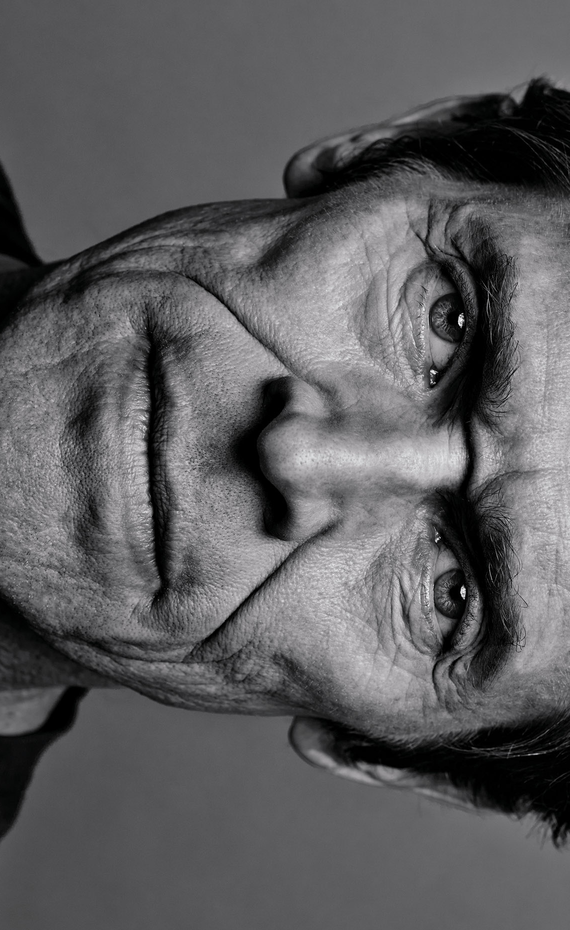

In [580]:
basename = "dafoe"

scale = 2
# image_name = "images/moonface.png"
# image_name = "images/einstein.jpg"
# image_name = "images/david-bowie.jpg"
# image_name  = "images/scary_penguin.webp"
# image_name = "images/portrait_1.jpg"
image_name = "images/dafoe.jpg"

image = PIL.Image.open(image_name)

image = image.resize((int(image.width / scale), int(image.height / scale)), PIL.Image.ANTIALIAS)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
# image = image.filter(PIL.ImageFilter.SMOOTH_MORE)
# image = image.filter(PIL.ImageFilter.CONTOUR)
# image = image.filter(PIL.ImageFilter.DETAIL)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
# image = image.filter(PIL.ImageFilter.SMOOTH_MORE)

image = image.rotate(-90, expand=True)

image = image.convert("RGB")

width = image.width
height = image.height

display(image)

In [581]:
def move_to(gcode, x, y):
    gcode.move_to(
        ((x) / image.width) * (XMAX - XMIN) + XMIN,
        ((y) / image.height) * (YMAX - YMIN) + YMIN,
    )

In [582]:
gcode = GCODE(basename, feedrate=1500)
# gcode.move_to_starting_position()
# gcode.pen_down()
# gcode.draw_boundaries()
# gcode.pen_up()

gcode.pen_up()
gcode.move_to_mid_point()

In [583]:
point_cloud = []

pixel_step = 3

for x in range(0, image.width, pixel_step):
    for y in range(0, image.height, pixel_step):
        dx = uniform(-pixel_step / 2, pixel_step / 2)
        dy = uniform(-pixel_step / 2, pixel_step / 2)
        
        try:
            r, g, b = image.getpixel((x + dx, y + dy))
        except IndexError:
            continue
            
        intensity = ((255 - r) + (255 - g) + (255 - b)) / (255 * 3.0)
#         intensity = 1.0 - intensity
        
        if pow(intensity, 4) > uniform(0, 1):
            point_cloud.append((x + dx, y + dy))
            
print(len(point_cloud))

14284


In [584]:
min_dist = 5

kd_tree = KDTree(point_cloud)
close_points = kd_tree.query_pairs(min_dist)
print(len(close_points))

d = defaultdict(int)
for p1, p2 in close_points:
    d[p1] += 1
    d[p2] += 1

d_ = sorted(d.items(), key=itemgetter(1), reverse=True)

point_cloud = [x for index, x in enumerate(point_cloud) if index not in d or uniform(0, 1) > 0.5]
print(len(point_cloud))

27545
7996


In [585]:
point_cloud = [x for x in point_cloud if uniform(0, 1) > 0.25]
print(len(point_cloud)) 

5963


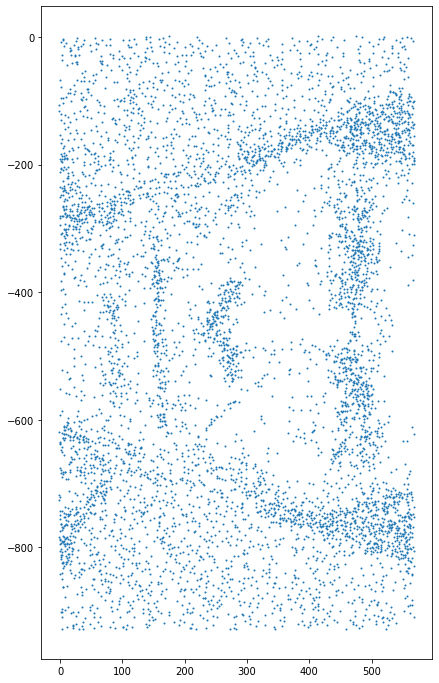

In [586]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 12))
plt.scatter(
    [x[0] for x in point_cloud], 
    [-x[1] for x in point_cloud],
    s=1,
)

In [587]:
tri = Delaunay(point_cloud, furthest_site=False)

In [588]:
for a, b, c in tri.simplices:
    p1 = point_cloud[a]
    p2 = point_cloud[b]
    p3 = point_cloud[c]
    
    gcode.pen_up()
    move_to(gcode, *p1)
    gcode.pen_down()
    move_to(gcode, *p2)
    move_to(gcode, *p3)
    move_to(gcode, *p1)
    gcode.pen_up()

In [589]:
gcode.pen_up()
gcode.move_to_starting_position()
gcode.flush()

In [590]:
preview_svg(basename)